In [1]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib

plt.rcParams["figure.figsize"] = (30, 20)

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from typing import Type, Any, Callable, Union, List, Dict, Optional, cast
from torch import Tensor
from collections import OrderedDict 
from torchvision.models.resnet import *
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls
from torch.hub import load_state_dict_from_url
from torchvision import transforms

In [3]:
IMAGE_PATH = "UTKface_inthewild"

In [4]:
FACIAL_LANDMARKS_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

In [5]:
class IntResNet(ResNet):
    def __init__(self,output_layer,*args):
        self.output_layer = output_layer
        super().__init__(*args)
        
        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [6]:
def new_resnet(
    arch: str,
    outlayer: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> IntResNet:

    '''model_urls = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
        'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
        'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
        'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
        'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
    }'''

    model = IntResNet(outlayer, block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [7]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight
        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth
    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)
        # extract the left and right eye (x, y)-coordinates
        (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]       
        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180  
        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]
        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist        
        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
            int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])        
        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
        # return the aligned face
        return output        

In [8]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [9]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=256)

In [10]:
mean_val = [0.485, 0.456, 0.406] 
std_val = [0.229, 0.224, 0.225]
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
model = new_resnet('resnet50','layer2',Bottleneck, [3, 4, 6, 3],True,True)
model = model.to('cuda:0')

C:\ProgramData\Anaconda3\envs\otus_env\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(


In [13]:
files_list = os.listdir(IMAGE_PATH)

In [14]:
print(files_list[:10])

['100_0_0_20170112213500903.jpg', '100_0_0_20170112215240346.jpg', '100_1_0_20170110183726390.jpg', '100_1_0_20170112213001988.jpg', '100_1_0_20170112213303693.jpg', '100_1_0_20170112215032192.jpg', '100_1_0_20170117195420803.jpg', '100_1_0_20170119212053665.jpg', '100_1_2_20170105174847679.jpg', '100_1_2_20170110182836729.jpg']


In [25]:
# files_list = [files_list[0]]

In [16]:
embedding_array = []
age_array = []
sex_array = []
i = 0
tensors_array = []
not_found = []

files_sublist = np.random.choice(files_list, size=15000, replace=False)
for file_name in files_sublist:
    image = cv2.imread(os.path.join(IMAGE_PATH, file_name), 1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        print("i = ", i)
        (x, y, w, h) = rect_to_bb(rects[0])
        faceAligned = fa.align(image.astype("uint8"), gray, rects[0])
        image= cv2.resize(faceAligned,dsize=(224,224), interpolation = cv2.INTER_AREA)
        np_image_data = np.asarray(image)
        
        tensor = preprocess(np_image_data)
        tensors_array.append(tensor)
        
        age_array.append(file_name[:file_name.find("_")])
        ind = file_name.find("_")+ 1
        sex_array.append(file_name[ind:file_name.find("_", ind)])
        print("shape age_array = \t", np.shape(age_array))
        print("shape embedding_array = \t", np.shape(embedding_array))
        print("shape tensors_array = \t", len(tensors_array))
        i = i + 1
        if i == 50:
            to_process = torch.stack(tensors_array, 0)
            print("shape to_process = ", np.shape(to_process))
            out = model(to_process.to('cuda:0'))
            out = out.cpu().data.numpy()
            embedding_array.extend(out[:,0,:,:])
            tensors_array = []
            i = 0
    else:
        not_found.append(file_name)
else:
    to_process = torch.stack(tensors_array, 0)
    print("shape to_process = ", np.shape(to_process))
    out = model(to_process.to('cuda:0'))
    out = out.cpu().data.numpy()
    embedding_array.extend(out[:,0,:,:])
    print("shape embedding_array = \t", np.shape(embedding_array))

i =  0
shape age_array = 	 (1,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (2,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (3,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (4,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (5,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (6,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (7,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (8,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (9,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (10,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (11,)
shape embedding_array = 	 (0,)
shape tensors_array = 	 11
i =  11
shape ag

i =  36
shape age_array = 	 (87,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (88,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (89,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (90,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (91,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (92,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (93,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (94,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (95,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (96,)
shape embedding_array = 	 (50, 28, 28)
shape tensors_array = 	 46


i =  17
shape age_array = 	 (168,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (169,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (170,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (171,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (172,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (173,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (174,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (175,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (176,)
shape embedding_array = 	 (150, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (177,)
shape embedding_array = 	 (150, 28, 28)
shape t

i =  48
shape age_array = 	 (249,)
shape embedding_array = 	 (200, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (250,)
shape embedding_array = 	 (200, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (251,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (252,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (253,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (254,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (255,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (256,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (257,)
shape embedding_array = 	 (250, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (258,)
shape embedd

i =  28
shape age_array = 	 (329,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (330,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (331,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (332,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (333,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (334,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (335,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (336,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (337,)
shape embedding_array = 	 (300, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (338,)
shape embedding_array = 	 (300, 28, 28)
shape t

i =  9
shape age_array = 	 (410,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (411,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (412,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (413,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (414,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (415,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (416,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (417,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (418,)
shape embedding_array = 	 (400, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (419,)
shape embedding_array = 	 (400, 28, 28)
shape te

i =  40
shape age_array = 	 (491,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (492,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (493,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (494,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (495,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (496,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (497,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (498,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (499,)
shape embedding_array = 	 (450, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (500,)
shape embedding_array = 	 (450, 28, 28)
shape t

i =  21
shape age_array = 	 (572,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (573,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (574,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (575,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (576,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (577,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (578,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (579,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (580,)
shape embedding_array = 	 (550, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (581,)
shape embedding_array = 	 (550, 28, 28)
shape t

i =  2
shape age_array = 	 (653,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (654,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (655,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (656,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (657,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (658,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (659,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (660,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (661,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (662,)
shape embedding_array = 	 (650, 28, 28)
shape tensors_array = 

i =  33
shape age_array = 	 (734,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (735,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (736,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (737,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (738,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (739,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (740,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (741,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (742,)
shape embedding_array = 	 (700, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (743,)
shape embedding_array = 	 (700, 28, 28)
shape t

i =  14
shape age_array = 	 (815,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (816,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (817,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (818,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (819,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (820,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (821,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (822,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (823,)
shape embedding_array = 	 (800, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (824,)
shape embedding_array = 	 (800, 28, 28)
shape t

i =  45
shape age_array = 	 (896,)
shape embedding_array = 	 (850, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (897,)
shape embedding_array = 	 (850, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (898,)
shape embedding_array = 	 (850, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (899,)
shape embedding_array = 	 (850, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (900,)
shape embedding_array = 	 (850, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (901,)
shape embedding_array = 	 (900, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (902,)
shape embedding_array = 	 (900, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (903,)
shape embedding_array = 	 (900, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (904,)
shape embedding_array = 	 (900, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (905,)
shape 

i =  26
shape age_array = 	 (977,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (978,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (979,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (980,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (981,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (982,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (983,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (984,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (985,)
shape embedding_array = 	 (950, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (986,)
shape embedding_array = 	 (950, 28, 28)
shape t

i =  5
shape age_array = 	 (1056,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (1057,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (1058,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (1059,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (1060,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (1061,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (1062,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (1063,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (1064,)
shape embedding_array = 	 (1050, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (1065,)
shape embedding_array = 	 (1050, 28, 

i =  35
shape age_array = 	 (1136,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (1137,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (1138,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (1139,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (1140,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (1141,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (1142,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (1143,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (1144,)
shape embedding_array = 	 (1100, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (1145,)
shape embedding_array = 	 (1

i =  14
shape age_array = 	 (1215,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (1216,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (1217,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (1218,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (1219,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (1220,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (1221,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (1222,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (1223,)
shape embedding_array = 	 (1200, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (1224,)
shape embedding_array = 	 (1

i =  43
shape age_array = 	 (1294,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (1295,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (1296,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (1297,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (1298,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (1299,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (1300,)
shape embedding_array = 	 (1250, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (1301,)
shape embedding_array = 	 (1300, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (1302,)
shape embedding_array = 	 (1300, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_a

i =  23
shape age_array = 	 (1374,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (1375,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (1376,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (1377,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (1378,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (1379,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (1380,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (1381,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (1382,)
shape embedding_array = 	 (1350, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (1383,)
shape embedding_array = 	 (1

i =  3
shape age_array = 	 (1454,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (1455,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (1456,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (1457,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (1458,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (1459,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (1460,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (1461,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (1462,)
shape embedding_array = 	 (1450, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (1463,)
shape embedding_array = 	 (1450, 28, 28)


shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (1534,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (1535,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (1536,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (1537,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (1538,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (1539,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (1540,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (1541,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (1542,)
shape embedding_array = 	 (1500, 28, 28)
shape tensors_array = 	

shape age_array = 	 (1612,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (1613,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (1614,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (1615,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (1616,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (1617,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (1618,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (1619,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (1620,)
shape embedding_array = 	 (1600, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (1621,)
shape embedding_array = 	 (1600, 28,

i =  40
shape age_array = 	 (1691,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (1692,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (1693,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (1694,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (1695,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (1696,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (1697,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (1698,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (1699,)
shape embedding_array = 	 (1650, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (1700,)
shape embedding_array = 	 (1

i =  19
shape age_array = 	 (1770,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (1771,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (1772,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (1773,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (1774,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (1775,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (1776,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (1777,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (1778,)
shape embedding_array = 	 (1750, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (1779,)
shape embedding_array = 	 (1

i =  49
shape age_array = 	 (1850,)
shape embedding_array = 	 (1800, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (1851,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (1852,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (1853,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (1854,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (1855,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (1856,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (1857,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (1858,)
shape embedding_array = 	 (1850, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (18

i =  28
shape age_array = 	 (1929,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (1930,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (1931,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (1932,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (1933,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (1934,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (1935,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (1936,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (1937,)
shape embedding_array = 	 (1900, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (1938,)
shape embedding_array = 	 (1

i =  8
shape age_array = 	 (2009,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (2010,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (2011,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (2012,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (2013,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (2014,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (2015,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (2016,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (2017,)
shape embedding_array = 	 (2000, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (2018,)
shape embedding_array = 	 (2000

i =  39
shape age_array = 	 (2090,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (2091,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (2092,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (2093,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (2094,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (2095,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (2096,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (2097,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (2098,)
shape embedding_array = 	 (2050, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (2099,)
shape embedding_array = 	 (2

shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (2169,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (2170,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (2171,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (2172,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (2173,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (2174,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (2175,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (2176,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (2177,)
shape embedding_array = 	 (2150, 28, 28)
shape tensors_array = 	

i =  46
shape age_array = 	 (2247,)
shape embedding_array = 	 (2200, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (2248,)
shape embedding_array = 	 (2200, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (2249,)
shape embedding_array = 	 (2200, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (2250,)
shape embedding_array = 	 (2200, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (2251,)
shape embedding_array = 	 (2250, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (2252,)
shape embedding_array = 	 (2250, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (2253,)
shape embedding_array = 	 (2250, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (2254,)
shape embedding_array = 	 (2250, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (2255,)
shape embedding_array = 	 (2250, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array =

i =  25
shape age_array = 	 (2326,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (2327,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (2328,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (2329,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (2330,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (2331,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (2332,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (2333,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (2334,)
shape embedding_array = 	 (2300, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (2335,)
shape embedding_array = 	 (2

i =  5
shape age_array = 	 (2406,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (2407,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (2408,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (2409,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (2410,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (2411,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (2412,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (2413,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (2414,)
shape embedding_array = 	 (2400, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (2415,)
shape embedding_array = 	 (2400, 28, 

i =  34
shape age_array = 	 (2485,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (2486,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (2487,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (2488,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (2489,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (2490,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (2491,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (2492,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (2493,)
shape embedding_array = 	 (2450, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (2494,)
shape embedding_array = 	 (2

i =  14
shape age_array = 	 (2565,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (2566,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (2567,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (2568,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (2569,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (2570,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (2571,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (2572,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (2573,)
shape embedding_array = 	 (2550, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (2574,)
shape embedding_array = 	 (2

i =  43
shape age_array = 	 (2644,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (2645,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (2646,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (2647,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (2648,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (2649,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (2650,)
shape embedding_array = 	 (2600, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (2651,)
shape embedding_array = 	 (2650, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (2652,)
shape embedding_array = 	 (2650, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_a

i =  23
shape age_array = 	 (2724,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (2725,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (2726,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (2727,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (2728,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (2729,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (2730,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (2731,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (2732,)
shape embedding_array = 	 (2700, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (2733,)
shape embedding_array = 	 (2

i =  2
shape age_array = 	 (2803,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (2804,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (2805,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (2806,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (2807,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (2808,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (2809,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (2810,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (2811,)
shape embedding_array = 	 (2800, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (2812,)
shape embedding_array = 	 (2800, 28, 28)
sh

shape age_array = 	 (2884,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (2885,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (2886,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (2887,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (2888,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (2889,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (2890,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (2891,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (2892,)
shape embedding_array = 	 (2850, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (2893,)
shape embedding_array = 	 (2850, 28,

i =  12
shape age_array = 	 (2963,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (2964,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (2965,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (2966,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (2967,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (2968,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (2969,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (2970,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (2971,)
shape embedding_array = 	 (2950, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (2972,)
shape embedding_array = 	 (2

i =  41
shape age_array = 	 (3042,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (3043,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (3044,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (3045,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (3046,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (3047,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (3048,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (3049,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (3050,)
shape embedding_array = 	 (3000, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape a

shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (3121,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (3122,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (3123,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (3124,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (3125,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (3126,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (3127,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (3128,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (3129,)
shape embedding_array = 	 (3100, 28, 28)
shape tensors_array = 	

i =  49
shape age_array = 	 (3200,)
shape embedding_array = 	 (3150, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (3201,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (3202,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (3203,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (3204,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (3205,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (3206,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (3207,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (3208,)
shape embedding_array = 	 (3200, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (32

i =  28
shape age_array = 	 (3279,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (3280,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (3281,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (3282,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (3283,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (3284,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (3285,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (3286,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (3287,)
shape embedding_array = 	 (3250, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (3288,)
shape embedding_array = 	 (3

i =  8
shape age_array = 	 (3359,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (3360,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (3361,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (3362,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (3363,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (3364,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (3365,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (3366,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (3367,)
shape embedding_array = 	 (3350, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (3368,)
shape embedding_array = 	 (3350

i =  37
shape age_array = 	 (3438,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (3439,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (3440,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (3441,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (3442,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (3443,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (3444,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (3445,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (3446,)
shape embedding_array = 	 (3400, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (3447,)
shape embedding_array = 	 (3

shape age_array = 	 (3517,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (3518,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (3519,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (3520,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (3521,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (3522,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (3523,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (3524,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (3525,)
shape embedding_array = 	 (3500, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (3526,)
shape embedding_array = 	 (3500, 28,

i =  45
shape age_array = 	 (3596,)
shape embedding_array = 	 (3550, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (3597,)
shape embedding_array = 	 (3550, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (3598,)
shape embedding_array = 	 (3550, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (3599,)
shape embedding_array = 	 (3550, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (3600,)
shape embedding_array = 	 (3550, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (3601,)
shape embedding_array = 	 (3600, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (3602,)
shape embedding_array = 	 (3600, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (3603,)
shape embedding_array = 	 (3600, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (3604,)
shape embedding_array = 	 (3600, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array

i =  24
shape age_array = 	 (3675,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (3676,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (3677,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (3678,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (3679,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (3680,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (3681,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (3682,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (3683,)
shape embedding_array = 	 (3650, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (3684,)
shape embedding_array = 	 (3

i =  4
shape age_array = 	 (3755,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (3756,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (3757,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (3758,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (3759,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (3760,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (3761,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (3762,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (3763,)
shape embedding_array = 	 (3750, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (3764,)
shape embedding_array = 	 (3750, 28, 28

i =  34
shape age_array = 	 (3835,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (3836,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (3837,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (3838,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (3839,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (3840,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (3841,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (3842,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (3843,)
shape embedding_array = 	 (3800, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (3844,)
shape embedding_array = 	 (3

i =  13
shape age_array = 	 (3914,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (3915,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (3916,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (3917,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (3918,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (3919,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (3920,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (3921,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (3922,)
shape embedding_array = 	 (3900, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (3923,)
shape embedding_array = 	 (3

i =  42
shape age_array = 	 (3993,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (3994,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (3995,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (3996,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (3997,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (3998,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (3999,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (4000,)
shape embedding_array = 	 (3950, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (4001,)
shape embedding_array = 	 (4000, 28, 28)
shape tensors_array = 	 1
i =  1
shape age

i =  21
shape age_array = 	 (4072,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (4073,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (4074,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (4075,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (4076,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (4077,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (4078,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (4079,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (4080,)
shape embedding_array = 	 (4050, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (4081,)
shape embedding_array = 	 (4

i =  0
shape age_array = 	 (4151,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (4152,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (4153,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (4154,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (4155,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (4156,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (4157,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (4158,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (4159,)
shape embedding_array = 	 (4150, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (4160,)
shape embedding_array = 	 (4150, 28, 28)
shape 

i =  29
shape age_array = 	 (4230,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (4231,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (4232,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (4233,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (4234,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (4235,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (4236,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (4237,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (4238,)
shape embedding_array = 	 (4200, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (4239,)
shape embedding_array = 	 (4

i =  8
shape age_array = 	 (4309,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (4310,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (4311,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (4312,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (4313,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (4314,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (4315,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (4316,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (4317,)
shape embedding_array = 	 (4300, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (4318,)
shape embedding_array = 	 (4300

i =  37
shape age_array = 	 (4388,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (4389,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (4390,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (4391,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (4392,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (4393,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (4394,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (4395,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (4396,)
shape embedding_array = 	 (4350, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (4397,)
shape embedding_array = 	 (4

i =  16
shape age_array = 	 (4467,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (4468,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (4469,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (4470,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (4471,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (4472,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (4473,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (4474,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (4475,)
shape embedding_array = 	 (4450, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (4476,)
shape embedding_array = 	 (4

i =  46
shape age_array = 	 (4547,)
shape embedding_array = 	 (4500, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (4548,)
shape embedding_array = 	 (4500, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (4549,)
shape embedding_array = 	 (4500, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (4550,)
shape embedding_array = 	 (4500, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (4551,)
shape embedding_array = 	 (4550, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (4552,)
shape embedding_array = 	 (4550, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (4553,)
shape embedding_array = 	 (4550, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (4554,)
shape embedding_array = 	 (4550, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (4555,)
shape embedding_array = 	 (4550, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array =

shape age_array = 	 (4627,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (4628,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (4629,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (4630,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (4631,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (4632,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (4633,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (4634,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (4635,)
shape embedding_array = 	 (4600, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (4636,)
shape embedding_array = 	 (4600, 28,

shape age_array = 	 (4706,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (4707,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (4708,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (4709,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (4710,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (4711,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (4712,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (4713,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (4714,)
shape embedding_array = 	 (4700, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (4715,)
shape embedding_array = 	 (4700, 28, 28)
sha

i =  34
shape age_array = 	 (4785,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (4786,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (4787,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (4788,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (4789,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (4790,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (4791,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (4792,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (4793,)
shape embedding_array = 	 (4750, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (4794,)
shape embedding_array = 	 (4

i =  13
shape age_array = 	 (4864,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (4865,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (4866,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (4867,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (4868,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (4869,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (4870,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (4871,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (4872,)
shape embedding_array = 	 (4850, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (4873,)
shape embedding_array = 	 (4

i =  42
shape age_array = 	 (4943,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (4944,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (4945,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (4946,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (4947,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (4948,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (4949,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (4950,)
shape embedding_array = 	 (4900, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (4951,)
shape embedding_array = 	 (4950, 28, 28)
shape tensors_array = 	 1
i =  1
shape age

i =  23
shape age_array = 	 (5024,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (5025,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (5026,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (5027,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (5028,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (5029,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (5030,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (5031,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (5032,)
shape embedding_array = 	 (5000, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (5033,)
shape embedding_array = 	 (5

i =  2
shape age_array = 	 (5103,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (5104,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (5105,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (5106,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (5107,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (5108,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (5109,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (5110,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (5111,)
shape embedding_array = 	 (5100, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (5112,)
shape embedding_array = 	 (5100, 28, 28)
sh

shape age_array = 	 (5183,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (5184,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (5185,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (5186,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (5187,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (5188,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (5189,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (5190,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (5191,)
shape embedding_array = 	 (5150, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (5192,)
shape embedding_array = 	 (5150, 28,

i =  11
shape age_array = 	 (5262,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (5263,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (5264,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (5265,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (5266,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (5267,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (5268,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (5269,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (5270,)
shape embedding_array = 	 (5250, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (5271,)
shape embedding_array = 	 (5

i =  40
shape age_array = 	 (5341,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (5342,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (5343,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (5344,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (5345,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (5346,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (5347,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (5348,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (5349,)
shape embedding_array = 	 (5300, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (5350,)
shape embedding_array = 	 (5

i =  19
shape age_array = 	 (5420,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (5421,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (5422,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (5423,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (5424,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (5425,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (5426,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (5427,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (5428,)
shape embedding_array = 	 (5400, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (5429,)
shape embedding_array = 	 (5

i =  48
shape age_array = 	 (5499,)
shape embedding_array = 	 (5450, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (5500,)
shape embedding_array = 	 (5450, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (5501,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (5502,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (5503,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (5504,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (5505,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (5506,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (5507,)
shape embedding_array = 	 (5500, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (

shape age_array = 	 (5577,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (5578,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (5579,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (5580,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (5581,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (5582,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (5583,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (5584,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (5585,)
shape embedding_array = 	 (5550, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (5586,)
shape embedding_array = 	 (5550, 28,

i =  5
shape age_array = 	 (5656,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (5657,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (5658,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (5659,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (5660,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (5661,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (5662,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (5663,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (5664,)
shape embedding_array = 	 (5650, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (5665,)
shape embedding_array = 	 (5650, 28, 

i =  34
shape age_array = 	 (5735,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (5736,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (5737,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (5738,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (5739,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (5740,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (5741,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (5742,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (5743,)
shape embedding_array = 	 (5700, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (5744,)
shape embedding_array = 	 (5

i =  13
shape age_array = 	 (5814,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (5815,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (5816,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (5817,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (5818,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (5819,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (5820,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (5821,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (5822,)
shape embedding_array = 	 (5800, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (5823,)
shape embedding_array = 	 (5

i =  42
shape age_array = 	 (5893,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (5894,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (5895,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (5896,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (5897,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (5898,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (5899,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (5900,)
shape embedding_array = 	 (5850, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (5901,)
shape embedding_array = 	 (5900, 28, 28)
shape tensors_array = 	 1
i =  1
shape age

i =  21
shape age_array = 	 (5972,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (5973,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (5974,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (5975,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (5976,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (5977,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (5978,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (5979,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (5980,)
shape embedding_array = 	 (5950, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (5981,)
shape embedding_array = 	 (5

i =  0
shape age_array = 	 (6051,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (6052,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (6053,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (6054,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (6055,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (6056,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (6057,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (6058,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (6059,)
shape embedding_array = 	 (6050, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (6060,)
shape embedding_array = 	 (6050, 28, 28)
shape 

i =  29
shape age_array = 	 (6130,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (6131,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (6132,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (6133,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (6134,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (6135,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (6136,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (6137,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (6138,)
shape embedding_array = 	 (6100, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (6139,)
shape embedding_array = 	 (6

i =  8
shape age_array = 	 (6209,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (6210,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (6211,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (6212,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (6213,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (6214,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (6215,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (6216,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (6217,)
shape embedding_array = 	 (6200, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (6218,)
shape embedding_array = 	 (6200

i =  38
shape age_array = 	 (6289,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (6290,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (6291,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (6292,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (6293,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (6294,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (6295,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (6296,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (6297,)
shape embedding_array = 	 (6250, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (6298,)
shape embedding_array = 	 (6

i =  17
shape age_array = 	 (6368,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (6369,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (6370,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (6371,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (6372,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (6373,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (6374,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (6375,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (6376,)
shape embedding_array = 	 (6350, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (6377,)
shape embedding_array = 	 (6

i =  46
shape age_array = 	 (6447,)
shape embedding_array = 	 (6400, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (6448,)
shape embedding_array = 	 (6400, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (6449,)
shape embedding_array = 	 (6400, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (6450,)
shape embedding_array = 	 (6400, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (6451,)
shape embedding_array = 	 (6450, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (6452,)
shape embedding_array = 	 (6450, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (6453,)
shape embedding_array = 	 (6450, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (6454,)
shape embedding_array = 	 (6450, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (6455,)
shape embedding_array = 	 (6450, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array =

i =  26
shape age_array = 	 (6527,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (6528,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (6529,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (6530,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (6531,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (6532,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (6533,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (6534,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (6535,)
shape embedding_array = 	 (6500, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (6536,)
shape embedding_array = 	 (6

i =  5
shape age_array = 	 (6606,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (6607,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (6608,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (6609,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (6610,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (6611,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (6612,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (6613,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (6614,)
shape embedding_array = 	 (6600, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (6615,)
shape embedding_array = 	 (6600, 28, 

i =  34
shape age_array = 	 (6685,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (6686,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (6687,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (6688,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (6689,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (6690,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (6691,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (6692,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (6693,)
shape embedding_array = 	 (6650, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (6694,)
shape embedding_array = 	 (6

i =  13
shape age_array = 	 (6764,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (6765,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (6766,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (6767,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (6768,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (6769,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (6770,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (6771,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (6772,)
shape embedding_array = 	 (6750, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (6773,)
shape embedding_array = 	 (6

i =  43
shape age_array = 	 (6844,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (6845,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (6846,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (6847,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (6848,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (6849,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (6850,)
shape embedding_array = 	 (6800, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (6851,)
shape embedding_array = 	 (6850, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (6852,)
shape embedding_array = 	 (6850, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_a

shape age_array = 	 (6923,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (6924,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (6925,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (6926,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (6927,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (6928,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (6929,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (6930,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (6931,)
shape embedding_array = 	 (6900, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (6932,)
shape embedding_array = 	 (6900, 28,

i =  1
shape age_array = 	 (7002,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (7003,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (7004,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (7005,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (7006,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (7007,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (7008,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (7009,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (7010,)
shape embedding_array = 	 (7000, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (7011,)
shape embedding_array = 	 (7000, 28, 28)
shap

i =  31
shape age_array = 	 (7082,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (7083,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (7084,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (7085,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (7086,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (7087,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (7088,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (7089,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (7090,)
shape embedding_array = 	 (7050, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (7091,)
shape embedding_array = 	 (7

i =  10
shape age_array = 	 (7161,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (7162,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (7163,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (7164,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (7165,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (7166,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (7167,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (7168,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (7169,)
shape embedding_array = 	 (7150, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (7170,)
shape embedding_array = 	 (7

i =  40
shape age_array = 	 (7241,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (7242,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (7243,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (7244,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (7245,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (7246,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (7247,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (7248,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (7249,)
shape embedding_array = 	 (7200, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (7250,)
shape embedding_array = 	 (7

i =  19
shape age_array = 	 (7320,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (7321,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (7322,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (7323,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (7324,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (7325,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (7326,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (7327,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (7328,)
shape embedding_array = 	 (7300, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (7329,)
shape embedding_array = 	 (7

i =  49
shape age_array = 	 (7400,)
shape embedding_array = 	 (7350, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (7401,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (7402,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (7403,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (7404,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (7405,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (7406,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (7407,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (7408,)
shape embedding_array = 	 (7400, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (74

i =  28
shape age_array = 	 (7479,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (7480,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (7481,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (7482,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (7483,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (7484,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (7485,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (7486,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (7487,)
shape embedding_array = 	 (7450, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (7488,)
shape embedding_array = 	 (7

i =  7
shape age_array = 	 (7558,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (7559,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (7560,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (7561,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (7562,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (7563,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (7564,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (7565,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (7566,)
shape embedding_array = 	 (7550, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (7567,)
shape embedding_array = 	 (7550, 

i =  37
shape age_array = 	 (7638,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (7639,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (7640,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (7641,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (7642,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (7643,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (7644,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (7645,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (7646,)
shape embedding_array = 	 (7600, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (7647,)
shape embedding_array = 	 (7

i =  16
shape age_array = 	 (7717,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (7718,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (7719,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (7720,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (7721,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (7722,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (7723,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (7724,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (7725,)
shape embedding_array = 	 (7700, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (7726,)
shape embedding_array = 	 (7

i =  46
shape age_array = 	 (7797,)
shape embedding_array = 	 (7750, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (7798,)
shape embedding_array = 	 (7750, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (7799,)
shape embedding_array = 	 (7750, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (7800,)
shape embedding_array = 	 (7750, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (7801,)
shape embedding_array = 	 (7800, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (7802,)
shape embedding_array = 	 (7800, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (7803,)
shape embedding_array = 	 (7800, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (7804,)
shape embedding_array = 	 (7800, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (7805,)
shape embedding_array = 	 (7800, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array =

shape age_array = 	 (7877,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (7878,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (7879,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (7880,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (7881,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (7882,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (7883,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (7884,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (7885,)
shape embedding_array = 	 (7850, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (7886,)
shape embedding_array = 	 (7850, 28,

shape age_array = 	 (7956,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (7957,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (7958,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (7959,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (7960,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (7961,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (7962,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (7963,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (7964,)
shape embedding_array = 	 (7950, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (7965,)
shape embedding_array = 	 (7950, 28, 28)
sha

i =  34
shape age_array = 	 (8035,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (8036,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (8037,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (8038,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (8039,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (8040,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (8041,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (8042,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (8043,)
shape embedding_array = 	 (8000, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (8044,)
shape embedding_array = 	 (8

i =  13
shape age_array = 	 (8114,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (8115,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (8116,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (8117,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (8118,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (8119,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (8120,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (8121,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (8122,)
shape embedding_array = 	 (8100, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (8123,)
shape embedding_array = 	 (8

i =  42
shape age_array = 	 (8193,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (8194,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (8195,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (8196,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (8197,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (8198,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (8199,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (8200,)
shape embedding_array = 	 (8150, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (8201,)
shape embedding_array = 	 (8200, 28, 28)
shape tensors_array = 	 1
i =  1
shape age

shape age_array = 	 (8272,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (8273,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (8274,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (8275,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (8276,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (8277,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (8278,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (8279,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (8280,)
shape embedding_array = 	 (8250, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (8281,)
shape embedding_array = 	 (8250, 28,

i =  0
shape age_array = 	 (8351,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (8352,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (8353,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (8354,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (8355,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (8356,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (8357,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (8358,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (8359,)
shape embedding_array = 	 (8350, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (8360,)
shape embedding_array = 	 (8350, 28, 28)
shape 

i =  29
shape age_array = 	 (8430,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (8431,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (8432,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (8433,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (8434,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (8435,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (8436,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (8437,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (8438,)
shape embedding_array = 	 (8400, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (8439,)
shape embedding_array = 	 (8

i =  8
shape age_array = 	 (8509,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (8510,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (8511,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (8512,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (8513,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (8514,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (8515,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (8516,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (8517,)
shape embedding_array = 	 (8500, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (8518,)
shape embedding_array = 	 (8500

shape age_array = 	 (8588,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (8589,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (8590,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (8591,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (8592,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (8593,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (8594,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (8595,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (8596,)
shape embedding_array = 	 (8550, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (8597,)
shape embedding_array = 	 (8550, 28,

i =  17
shape age_array = 	 (8668,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (8669,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (8670,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (8671,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (8672,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (8673,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (8674,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (8675,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (8676,)
shape embedding_array = 	 (8650, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (8677,)
shape embedding_array = 	 (8

i =  46
shape age_array = 	 (8747,)
shape embedding_array = 	 (8700, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (8748,)
shape embedding_array = 	 (8700, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (8749,)
shape embedding_array = 	 (8700, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (8750,)
shape embedding_array = 	 (8700, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (8751,)
shape embedding_array = 	 (8750, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (8752,)
shape embedding_array = 	 (8750, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (8753,)
shape embedding_array = 	 (8750, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (8754,)
shape embedding_array = 	 (8750, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (8755,)
shape embedding_array = 	 (8750, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array =

i =  25
shape age_array = 	 (8826,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (8827,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (8828,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (8829,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (8830,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (8831,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (8832,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (8833,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (8834,)
shape embedding_array = 	 (8800, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (8835,)
shape embedding_array = 	 (8

i =  4
shape age_array = 	 (8905,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (8906,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (8907,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (8908,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (8909,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (8910,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (8911,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (8912,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (8913,)
shape embedding_array = 	 (8900, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (8914,)
shape embedding_array = 	 (8900, 28, 28

i =  33
shape age_array = 	 (8984,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (8985,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (8986,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (8987,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (8988,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (8989,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (8990,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (8991,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (8992,)
shape embedding_array = 	 (8950, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (8993,)
shape embedding_array = 	 (8

i =  13
shape age_array = 	 (9064,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (9065,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (9066,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (9067,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (9068,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (9069,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (9070,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (9071,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (9072,)
shape embedding_array = 	 (9050, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (9073,)
shape embedding_array = 	 (9

i =  42
shape age_array = 	 (9143,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (9144,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (9145,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (9146,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (9147,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (9148,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (9149,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (9150,)
shape embedding_array = 	 (9100, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (9151,)
shape embedding_array = 	 (9150, 28, 28)
shape tensors_array = 	 1
i =  1
shape age

i =  21
shape age_array = 	 (9222,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (9223,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (9224,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (9225,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (9226,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (9227,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (9228,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (9229,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (9230,)
shape embedding_array = 	 (9200, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (9231,)
shape embedding_array = 	 (9

i =  0
shape age_array = 	 (9301,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (9302,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (9303,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (9304,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (9305,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (9306,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (9307,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (9308,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (9309,)
shape embedding_array = 	 (9300, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (9310,)
shape embedding_array = 	 (9300, 28, 28)
shape 

i =  29
shape age_array = 	 (9380,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (9381,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (9382,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (9383,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (9384,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (9385,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (9386,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (9387,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (9388,)
shape embedding_array = 	 (9350, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (9389,)
shape embedding_array = 	 (9

shape age_array = 	 (9459,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (9460,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (9461,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (9462,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (9463,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (9464,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (9465,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (9466,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (9467,)
shape embedding_array = 	 (9450, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (9468,)
shape embedding_array = 	 (9450, 28, 2

i =  37
shape age_array = 	 (9538,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (9539,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (9540,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (9541,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (9542,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (9543,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (9544,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (9545,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (9546,)
shape embedding_array = 	 (9500, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (9547,)
shape embedding_array = 	 (9

i =  16
shape age_array = 	 (9617,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (9618,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (9619,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (9620,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (9621,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (9622,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (9623,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (9624,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (9625,)
shape embedding_array = 	 (9600, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (9626,)
shape embedding_array = 	 (9

i =  46
shape age_array = 	 (9697,)
shape embedding_array = 	 (9650, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (9698,)
shape embedding_array = 	 (9650, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (9699,)
shape embedding_array = 	 (9650, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (9700,)
shape embedding_array = 	 (9650, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (9701,)
shape embedding_array = 	 (9700, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (9702,)
shape embedding_array = 	 (9700, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (9703,)
shape embedding_array = 	 (9700, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (9704,)
shape embedding_array = 	 (9700, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (9705,)
shape embedding_array = 	 (9700, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array =

i =  26
shape age_array = 	 (9777,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (9778,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (9779,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (9780,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (9781,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (9782,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (9783,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (9784,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (9785,)
shape embedding_array = 	 (9750, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (9786,)
shape embedding_array = 	 (9

i =  5
shape age_array = 	 (9856,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (9857,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (9858,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (9859,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (9860,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (9861,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (9862,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (9863,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (9864,)
shape embedding_array = 	 (9850, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (9865,)
shape embedding_array = 	 (9850, 28, 

i =  34
shape age_array = 	 (9935,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (9936,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (9937,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (9938,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (9939,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (9940,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (9941,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (9942,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (9943,)
shape embedding_array = 	 (9900, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (9944,)
shape embedding_array = 	 (9

i =  12
shape age_array = 	 (10013,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (10014,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (10015,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (10016,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (10017,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (10018,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (10019,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (10020,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (10021,)
shape embedding_array = 	 (10000, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (10022,)
shape emb

i =  39
shape age_array = 	 (10090,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (10091,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (10092,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (10093,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (10094,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (10095,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (10096,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (10097,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (10098,)
shape embedding_array = 	 (10050, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (10099,)
shape emb

i =  16
shape age_array = 	 (10167,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (10168,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (10169,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (10170,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (10171,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (10172,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (10173,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (10174,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (10175,)
shape embedding_array = 	 (10150, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (10176,)
shape emb

shape age_array = 	 (10244,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (10245,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (10246,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (10247,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (10248,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (10249,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (10250,)
shape embedding_array = 	 (10200, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (10251,)
shape embedding_array = 	 (10250, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (10252,)
shape embedding_array = 	 (10250, 28, 28)
shape tensors_array = 	 2
i =  2
s

i =  20
shape age_array = 	 (10321,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (10322,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (10323,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (10324,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (10325,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (10326,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (10327,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (10328,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (10329,)
shape embedding_array = 	 (10300, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (10330,)
shape emb

i =  47
shape age_array = 	 (10398,)
shape embedding_array = 	 (10350, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (10399,)
shape embedding_array = 	 (10350, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (10400,)
shape embedding_array = 	 (10350, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (10401,)
shape embedding_array = 	 (10400, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (10402,)
shape embedding_array = 	 (10400, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (10403,)
shape embedding_array = 	 (10400, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (10404,)
shape embedding_array = 	 (10400, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (10405,)
shape embedding_array = 	 (10400, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (10406,)
shape embedding_array = 	 (10400, 28, 28)
shape tensors_array = 	 6
i =  6
s

i =  24
shape age_array = 	 (10475,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (10476,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (10477,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (10478,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (10479,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (10480,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (10481,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (10482,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (10483,)
shape embedding_array = 	 (10450, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (10484,)
shape emb

i =  2
shape age_array = 	 (10553,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (10554,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (10555,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (10556,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (10557,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (10558,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (10559,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (10560,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (10561,)
shape embedding_array = 	 (10550, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (10562,)
shape embedding_array = 

i =  30
shape age_array = 	 (10631,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (10632,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (10633,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (10634,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (10635,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (10636,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (10637,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (10638,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (10639,)
shape embedding_array = 	 (10600, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (10640,)
shape emb

i =  7
shape age_array = 	 (10708,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (10709,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (10710,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (10711,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (10712,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (10713,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (10714,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (10715,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (10716,)
shape embedding_array = 	 (10700, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (10717,)
shape embeddin

i =  35
shape age_array = 	 (10786,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (10787,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (10788,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (10789,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (10790,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (10791,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (10792,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (10793,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (10794,)
shape embedding_array = 	 (10750, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (10795,)
shape emb

i =  12
shape age_array = 	 (10863,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (10864,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (10865,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (10866,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (10867,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (10868,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (10869,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (10870,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (10871,)
shape embedding_array = 	 (10850, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (10872,)
shape emb

i =  39
shape age_array = 	 (10940,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (10941,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (10942,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (10943,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (10944,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (10945,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (10946,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (10947,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (10948,)
shape embedding_array = 	 (10900, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (10949,)
shape emb

i =  16
shape age_array = 	 (11017,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (11018,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (11019,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (11020,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (11021,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (11022,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (11023,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (11024,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (11025,)
shape embedding_array = 	 (11000, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (11026,)
shape emb

i =  43
shape age_array = 	 (11094,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (11095,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (11096,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (11097,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (11098,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (11099,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (11100,)
shape embedding_array = 	 (11050, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (11101,)
shape embedding_array = 	 (11100, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (11102,)
shape embedding_array = 	 (11100, 28, 28)
shape tensors_array = 	 2


i =  20
shape age_array = 	 (11171,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (11172,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (11173,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (11174,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (11175,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (11176,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (11177,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (11178,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (11179,)
shape embedding_array = 	 (11150, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (11180,)
shape emb

i =  47
shape age_array = 	 (11248,)
shape embedding_array = 	 (11200, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (11249,)
shape embedding_array = 	 (11200, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (11250,)
shape embedding_array = 	 (11200, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (11251,)
shape embedding_array = 	 (11250, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (11252,)
shape embedding_array = 	 (11250, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (11253,)
shape embedding_array = 	 (11250, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (11254,)
shape embedding_array = 	 (11250, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (11255,)
shape embedding_array = 	 (11250, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (11256,)
shape embedding_array = 	 (11250, 28, 28)
shape tensors_array = 	 6
i =  6
s

i =  25
shape age_array = 	 (11326,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (11327,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (11328,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (11329,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (11330,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (11331,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (11332,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (11333,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (11334,)
shape embedding_array = 	 (11300, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (11335,)
shape emb

i =  2
shape age_array = 	 (11403,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (11404,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (11405,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (11406,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (11407,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (11408,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (11409,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (11410,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (11411,)
shape embedding_array = 	 (11400, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (11412,)
shape embedding_array = 

i =  30
shape age_array = 	 (11481,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (11482,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (11483,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (11484,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (11485,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (11486,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (11487,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (11488,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (11489,)
shape embedding_array = 	 (11450, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (11490,)
shape emb

shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (11559,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (11560,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (11561,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (11562,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (11563,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (11564,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (11565,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (11566,)
shape embedding_array = 	 (11550, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (11567,)
shape embedding_array = 	 (11550, 28, 28)
shape te

i =  35
shape age_array = 	 (11636,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (11637,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (11638,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (11639,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (11640,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (11641,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (11642,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (11643,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (11644,)
shape embedding_array = 	 (11600, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (11645,)
shape emb

i =  12
shape age_array = 	 (11713,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (11714,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (11715,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (11716,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (11717,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (11718,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (11719,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (11720,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (11721,)
shape embedding_array = 	 (11700, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (11722,)
shape emb

i =  39
shape age_array = 	 (11790,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (11791,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (11792,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (11793,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (11794,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (11795,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (11796,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (11797,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (11798,)
shape embedding_array = 	 (11750, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (11799,)
shape emb

i =  17
shape age_array = 	 (11868,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (11869,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (11870,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (11871,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (11872,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (11873,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (11874,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (11875,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (11876,)
shape embedding_array = 	 (11850, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (11877,)
shape emb

i =  44
shape age_array = 	 (11945,)
shape embedding_array = 	 (11900, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (11946,)
shape embedding_array = 	 (11900, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (11947,)
shape embedding_array = 	 (11900, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (11948,)
shape embedding_array = 	 (11900, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (11949,)
shape embedding_array = 	 (11900, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (11950,)
shape embedding_array = 	 (11900, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (11951,)
shape embedding_array = 	 (11950, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (11952,)
shape embedding_array = 	 (11950, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (11953,)
shape embedding_array = 	 (11950, 28, 28)
shape tensors_array = 	 3
i 

i =  21
shape age_array = 	 (12022,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (12023,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (12024,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (12025,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (12026,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (12027,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (12028,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (12029,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (12030,)
shape embedding_array = 	 (12000, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (12031,)
shape emb

i =  49
shape age_array = 	 (12100,)
shape embedding_array = 	 (12050, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (12101,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (12102,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (12103,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (12104,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (12105,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (12106,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (12107,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (12108,)
shape embedding_array = 	 (12100, 28, 28)
shape tensors_array = 	 8
i =  8
shape

i =  26
shape age_array = 	 (12177,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (12178,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (12179,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (12180,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (12181,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (12182,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (12183,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (12184,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (12185,)
shape embedding_array = 	 (12150, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (12186,)
shape emb

i =  3
shape age_array = 	 (12254,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (12255,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (12256,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (12257,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (12258,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (12259,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (12260,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (12261,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (12262,)
shape embedding_array = 	 (12250, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (12263,)
shape embedding_array 

i =  31
shape age_array = 	 (12332,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (12333,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (12334,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (12335,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (12336,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (12337,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (12338,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (12339,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (12340,)
shape embedding_array = 	 (12300, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (12341,)
shape emb

i =  8
shape age_array = 	 (12409,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (12410,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (12411,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (12412,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (12413,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (12414,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (12415,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (12416,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (12417,)
shape embedding_array = 	 (12400, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (12418,)
shape embedd

shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (12488,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (12489,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (12490,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (12491,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (12492,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (12493,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (12494,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (12495,)
shape embedding_array = 	 (12450, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (12496,)
shape embedding_array = 	 (12450, 28, 28)
shap

i =  14
shape age_array = 	 (12565,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (12566,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (12567,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (12568,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (12569,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (12570,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (12571,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (12572,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (12573,)
shape embedding_array = 	 (12550, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (12574,)
shape emb

shape age_array = 	 (12642,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (12643,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (12644,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (12645,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (12646,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (12647,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (12648,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (12649,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (12650,)
shape embedding_array = 	 (12600, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i = 

i =  18
shape age_array = 	 (12719,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (12720,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (12721,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (12722,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (12723,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (12724,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (12725,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (12726,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (12727,)
shape embedding_array = 	 (12700, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (12728,)
shape emb

i =  45
shape age_array = 	 (12796,)
shape embedding_array = 	 (12750, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (12797,)
shape embedding_array = 	 (12750, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (12798,)
shape embedding_array = 	 (12750, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (12799,)
shape embedding_array = 	 (12750, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (12800,)
shape embedding_array = 	 (12750, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (12801,)
shape embedding_array = 	 (12800, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (12802,)
shape embedding_array = 	 (12800, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (12803,)
shape embedding_array = 	 (12800, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (12804,)
shape embedding_array = 	 (12800, 28, 28)
shape tensors_array = 	 4
i = 

i =  22
shape age_array = 	 (12873,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (12874,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (12875,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (12876,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (12877,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (12878,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (12879,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (12880,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (12881,)
shape embedding_array = 	 (12850, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (12882,)
shape emb

i =  49
shape age_array = 	 (12950,)
shape embedding_array = 	 (12900, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (12951,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (12952,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (12953,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (12954,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (12955,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (12956,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (12957,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (12958,)
shape embedding_array = 	 (12950, 28, 28)
shape tensors_array = 	 8
i =  8
shape

i =  26
shape age_array = 	 (13027,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (13028,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (13029,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (13030,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (13031,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (13032,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (13033,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (13034,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (13035,)
shape embedding_array = 	 (13000, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (13036,)
shape emb

i =  3
shape age_array = 	 (13104,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (13105,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (13106,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (13107,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (13108,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (13109,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (13110,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (13111,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (13112,)
shape embedding_array = 	 (13100, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (13113,)
shape embedding_array 

i =  31
shape age_array = 	 (13182,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (13183,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (13184,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (13185,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (13186,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (13187,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (13188,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (13189,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (13190,)
shape embedding_array = 	 (13150, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (13191,)
shape emb

i =  9
shape age_array = 	 (13260,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (13261,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (13262,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (13263,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (13264,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (13265,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (13266,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (13267,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (13268,)
shape embedding_array = 	 (13250, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (13269,)
shape embe

i =  38
shape age_array = 	 (13339,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (13340,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (13341,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (13342,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (13343,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (13344,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (13345,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (13346,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (13347,)
shape embedding_array = 	 (13300, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (13348,)
shape emb

shape age_array = 	 (13416,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (13417,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (13418,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (13419,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (13420,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (13421,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (13422,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (13423,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (13424,)
shape embedding_array = 	 (13400, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (13425,)
shape embedding_a

i =  43
shape age_array = 	 (13494,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (13495,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (13496,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (13497,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (13498,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (13499,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (13500,)
shape embedding_array = 	 (13450, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (13501,)
shape embedding_array = 	 (13500, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (13502,)
shape embedding_array = 	 (13500, 28, 28)
shape tensors_array = 	 2


i =  20
shape age_array = 	 (13571,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (13572,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (13573,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (13574,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (13575,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (13576,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (13577,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (13578,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (13579,)
shape embedding_array = 	 (13550, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (13580,)
shape emb

shape embedding_array = 	 (13600, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (13649,)
shape embedding_array = 	 (13600, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (13650,)
shape embedding_array = 	 (13600, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (13651,)
shape embedding_array = 	 (13650, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (13652,)
shape embedding_array = 	 (13650, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (13653,)
shape embedding_array = 	 (13650, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (13654,)
shape embedding_array = 	 (13650, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (13655,)
shape embedding_array = 	 (13650, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (13656,)
shape embedding_array = 	 (13650, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (13657,)
shape emb

i =  25
shape age_array = 	 (13726,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (13727,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (13728,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (13729,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (13730,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (13731,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (13732,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (13733,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (13734,)
shape embedding_array = 	 (13700, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (13735,)
shape emb

shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (13804,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (13805,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (13806,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 6
i =  6
shape age_array = 	 (13807,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 7
i =  7
shape age_array = 	 (13808,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (13809,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (13810,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (13811,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (13812,)
shape embedding_array = 	 (13800, 28, 28)
shape tensors_arra

i =  30
shape age_array = 	 (13881,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (13882,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (13883,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (13884,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 34
i =  34
shape age_array = 	 (13885,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 35
i =  35
shape age_array = 	 (13886,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (13887,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (13888,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (13889,)
shape embedding_array = 	 (13850, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (13890,)
shape emb

i =  7
shape age_array = 	 (13958,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 8
i =  8
shape age_array = 	 (13959,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 9
i =  9
shape age_array = 	 (13960,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 10
i =  10
shape age_array = 	 (13961,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 11
i =  11
shape age_array = 	 (13962,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 12
i =  12
shape age_array = 	 (13963,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (13964,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (13965,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (13966,)
shape embedding_array = 	 (13950, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (13967,)
shape embeddin

i =  35
shape age_array = 	 (14036,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 36
i =  36
shape age_array = 	 (14037,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 37
i =  37
shape age_array = 	 (14038,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 38
i =  38
shape age_array = 	 (14039,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 39
i =  39
shape age_array = 	 (14040,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (14041,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (14042,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (14043,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (14044,)
shape embedding_array = 	 (14000, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (14045,)
shape emb

i =  12
shape age_array = 	 (14113,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 13
i =  13
shape age_array = 	 (14114,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 14
i =  14
shape age_array = 	 (14115,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 15
i =  15
shape age_array = 	 (14116,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 16
i =  16
shape age_array = 	 (14117,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (14118,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (14119,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (14120,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (14121,)
shape embedding_array = 	 (14100, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (14122,)
shape emb

i =  39
shape age_array = 	 (14190,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 40
i =  40
shape age_array = 	 (14191,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 41
i =  41
shape age_array = 	 (14192,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 42
i =  42
shape age_array = 	 (14193,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 43
i =  43
shape age_array = 	 (14194,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (14195,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (14196,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (14197,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (14198,)
shape embedding_array = 	 (14150, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (14199,)
shape emb

i =  16
shape age_array = 	 (14267,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 17
i =  17
shape age_array = 	 (14268,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 18
i =  18
shape age_array = 	 (14269,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 19
i =  19
shape age_array = 	 (14270,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 20
i =  20
shape age_array = 	 (14271,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (14272,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (14273,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (14274,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (14275,)
shape embedding_array = 	 (14250, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (14276,)
shape emb

i =  43
shape age_array = 	 (14344,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 44
i =  44
shape age_array = 	 (14345,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 45
i =  45
shape age_array = 	 (14346,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 46
i =  46
shape age_array = 	 (14347,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 47
i =  47
shape age_array = 	 (14348,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (14349,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (14350,)
shape embedding_array = 	 (14300, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (14351,)
shape embedding_array = 	 (14350, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (14352,)
shape embedding_array = 	 (14350, 28, 28)
shape tensors_array = 	 2


i =  20
shape age_array = 	 (14421,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 21
i =  21
shape age_array = 	 (14422,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 22
i =  22
shape age_array = 	 (14423,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 23
i =  23
shape age_array = 	 (14424,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 24
i =  24
shape age_array = 	 (14425,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (14426,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (14427,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (14428,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (14429,)
shape embedding_array = 	 (14400, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (14430,)
shape emb

i =  47
shape age_array = 	 (14498,)
shape embedding_array = 	 (14450, 28, 28)
shape tensors_array = 	 48
i =  48
shape age_array = 	 (14499,)
shape embedding_array = 	 (14450, 28, 28)
shape tensors_array = 	 49
i =  49
shape age_array = 	 (14500,)
shape embedding_array = 	 (14450, 28, 28)
shape tensors_array = 	 50
shape to_process =  torch.Size([50, 3, 224, 224])
i =  0
shape age_array = 	 (14501,)
shape embedding_array = 	 (14500, 28, 28)
shape tensors_array = 	 1
i =  1
shape age_array = 	 (14502,)
shape embedding_array = 	 (14500, 28, 28)
shape tensors_array = 	 2
i =  2
shape age_array = 	 (14503,)
shape embedding_array = 	 (14500, 28, 28)
shape tensors_array = 	 3
i =  3
shape age_array = 	 (14504,)
shape embedding_array = 	 (14500, 28, 28)
shape tensors_array = 	 4
i =  4
shape age_array = 	 (14505,)
shape embedding_array = 	 (14500, 28, 28)
shape tensors_array = 	 5
i =  5
shape age_array = 	 (14506,)
shape embedding_array = 	 (14500, 28, 28)
shape tensors_array = 	 6
i =  6
s

i =  24
shape age_array = 	 (14575,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 25
i =  25
shape age_array = 	 (14576,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 26
i =  26
shape age_array = 	 (14577,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 27
i =  27
shape age_array = 	 (14578,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 28
i =  28
shape age_array = 	 (14579,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 29
i =  29
shape age_array = 	 (14580,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 30
i =  30
shape age_array = 	 (14581,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 31
i =  31
shape age_array = 	 (14582,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 32
i =  32
shape age_array = 	 (14583,)
shape embedding_array = 	 (14550, 28, 28)
shape tensors_array = 	 33
i =  33
shape age_array = 	 (14584,)
shape emb

In [18]:
len(not_found)

387

In [19]:
np.save("faces_not_found.npy", not_found)

In [20]:
np.save("age_array.npy", age_array)
np.save("sex_array.npy", sex_array)

In [21]:
np.save("embedding_array.npy", embedding_array)

In [22]:
np.save("files_sublist.npy", files_sublist)

In [27]:
sex_array[:5]

['1', '0', '0', '1', '1']

age =  25 	 sex =  woman


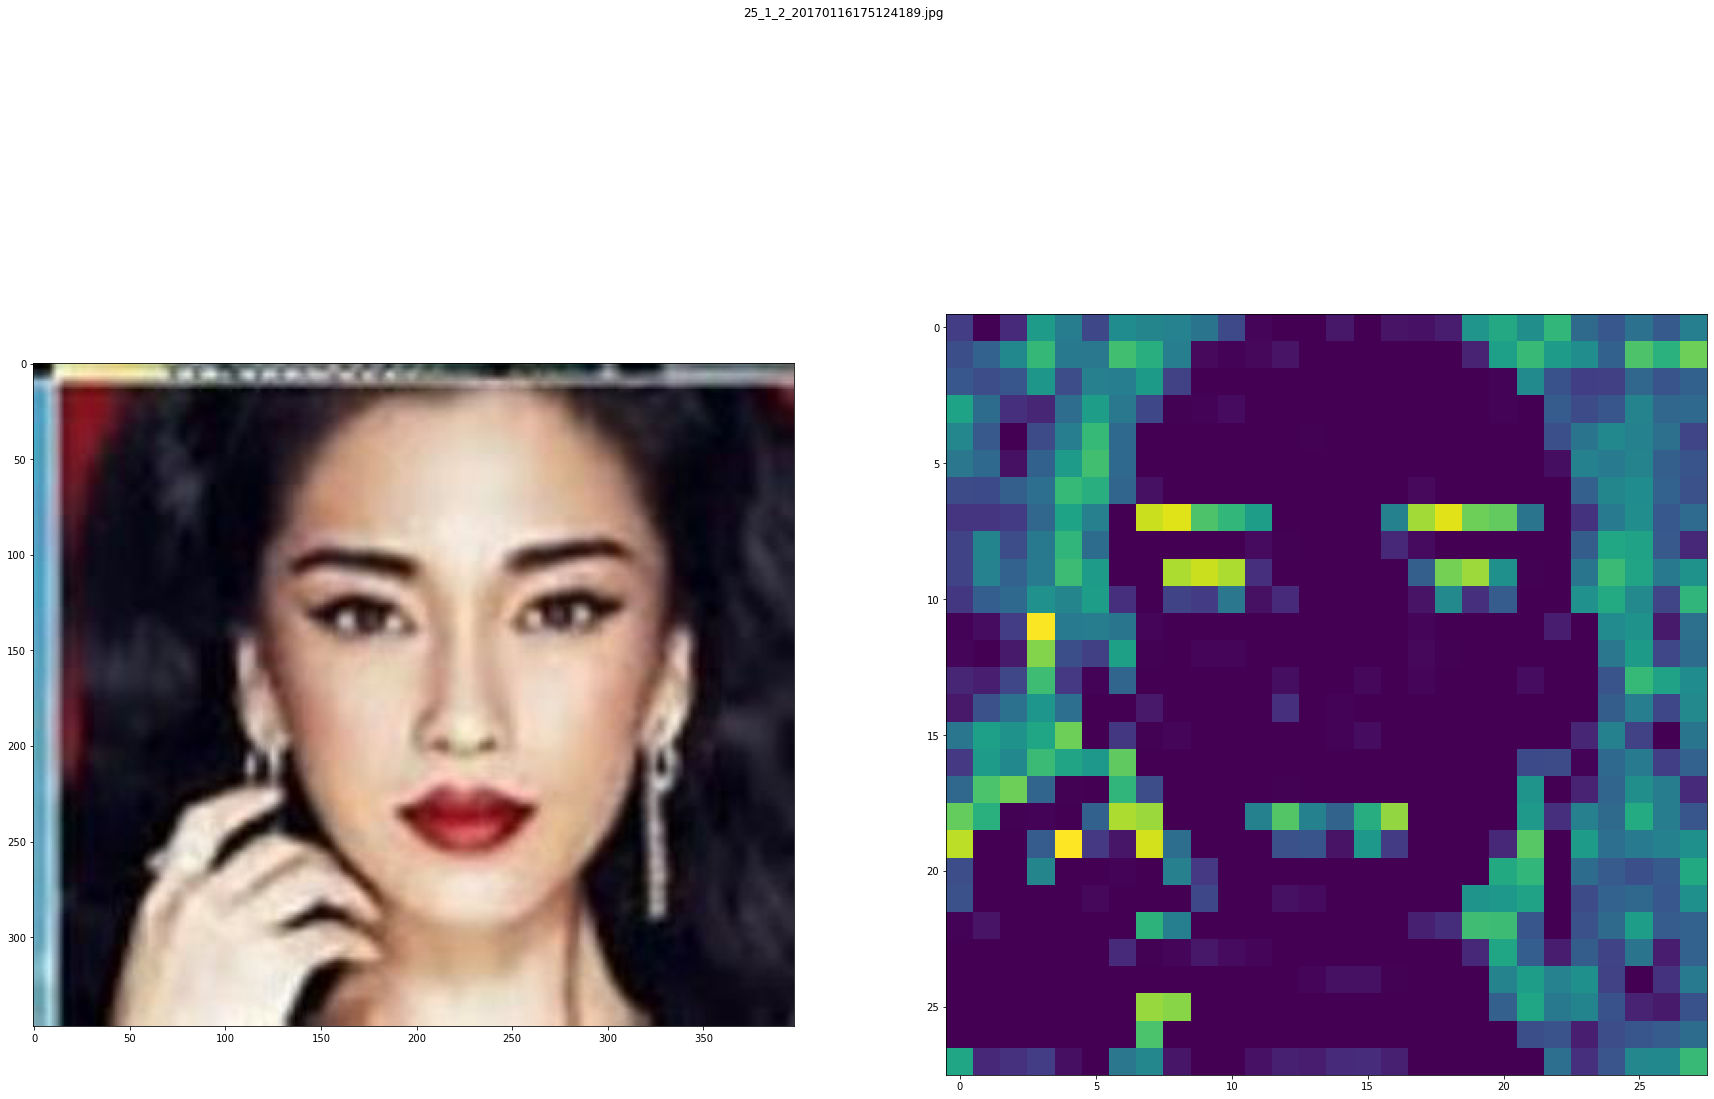

age =  1 	 sex =  man


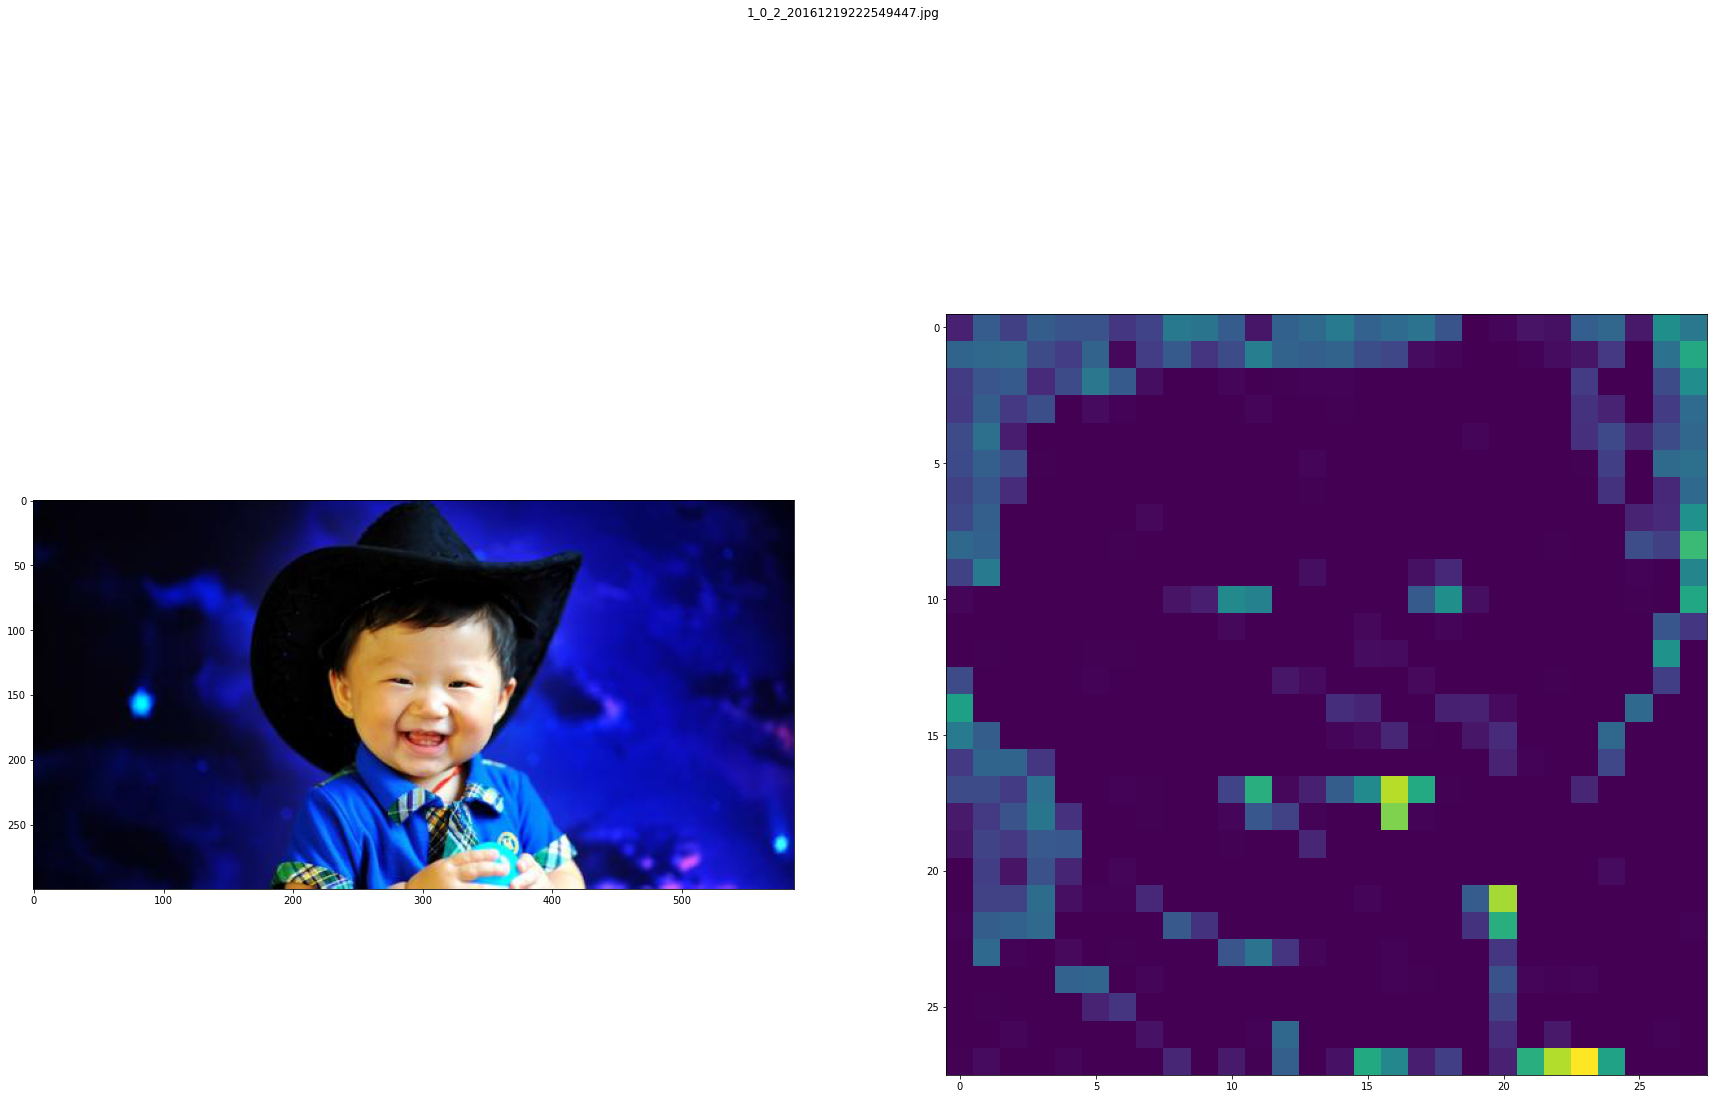

age =  61 	 sex =  man


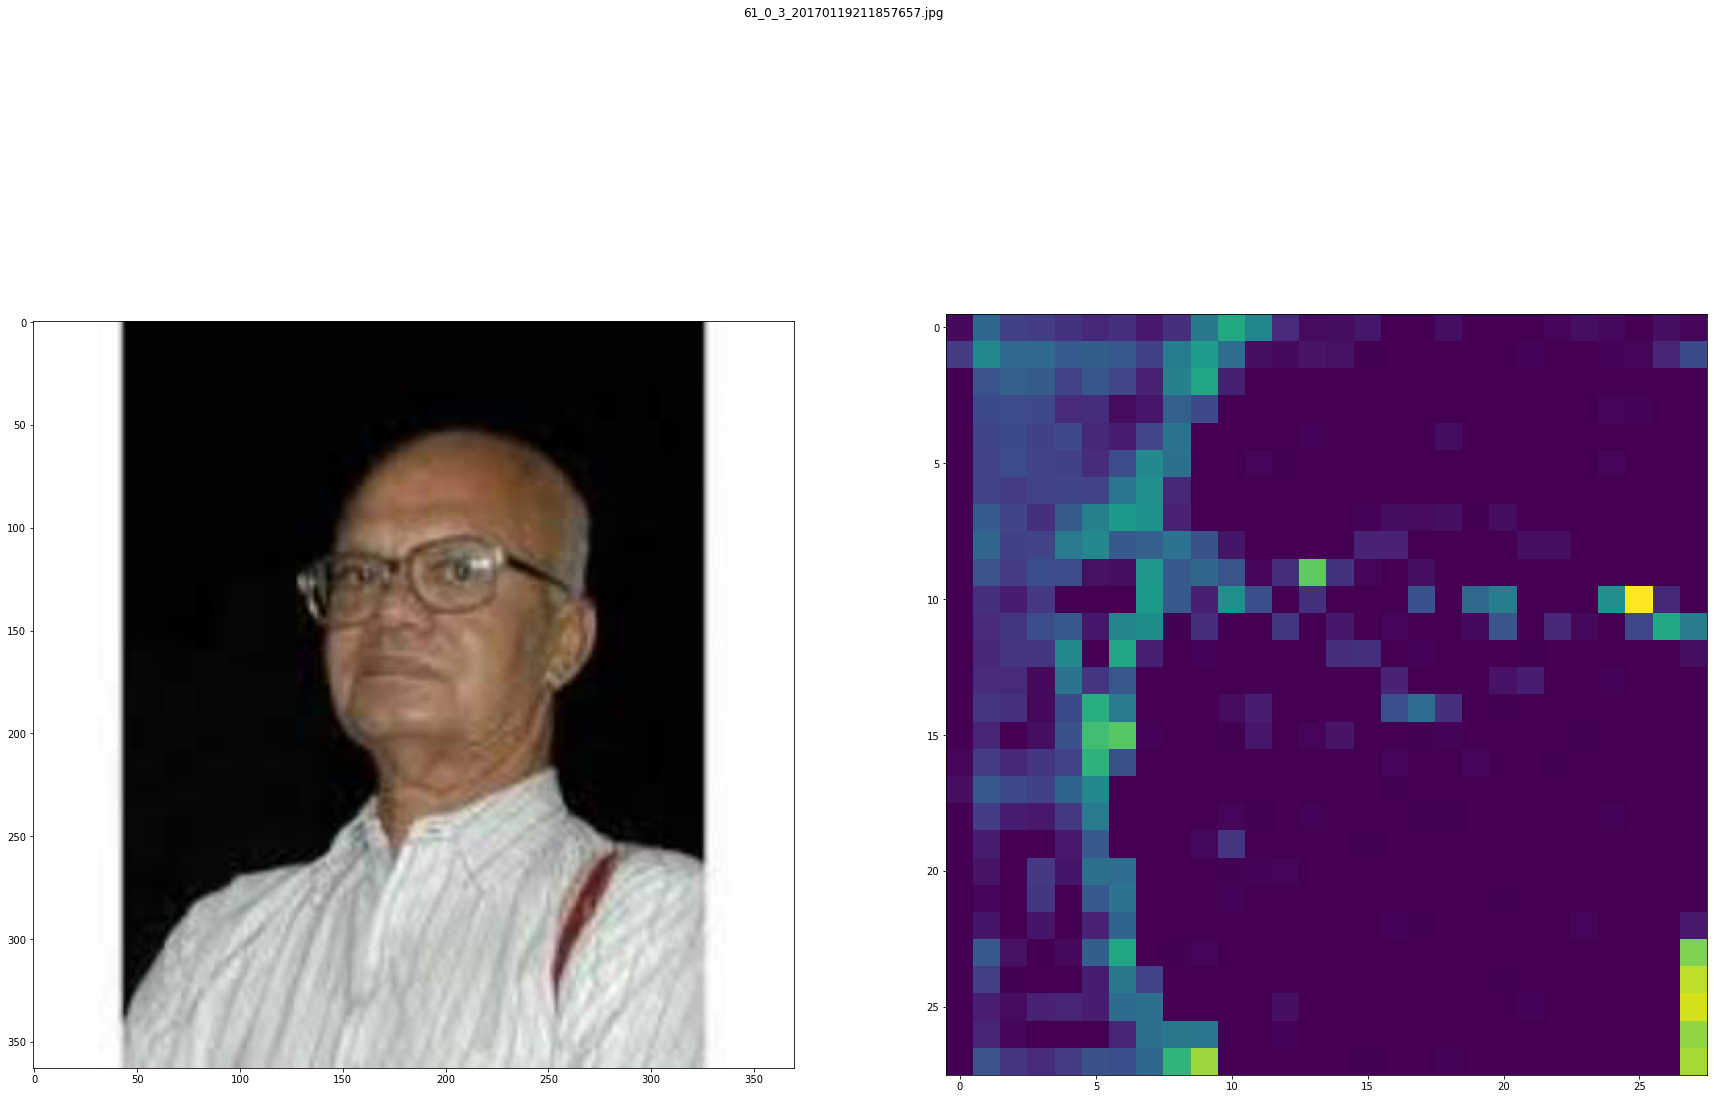

age =  26 	 sex =  woman


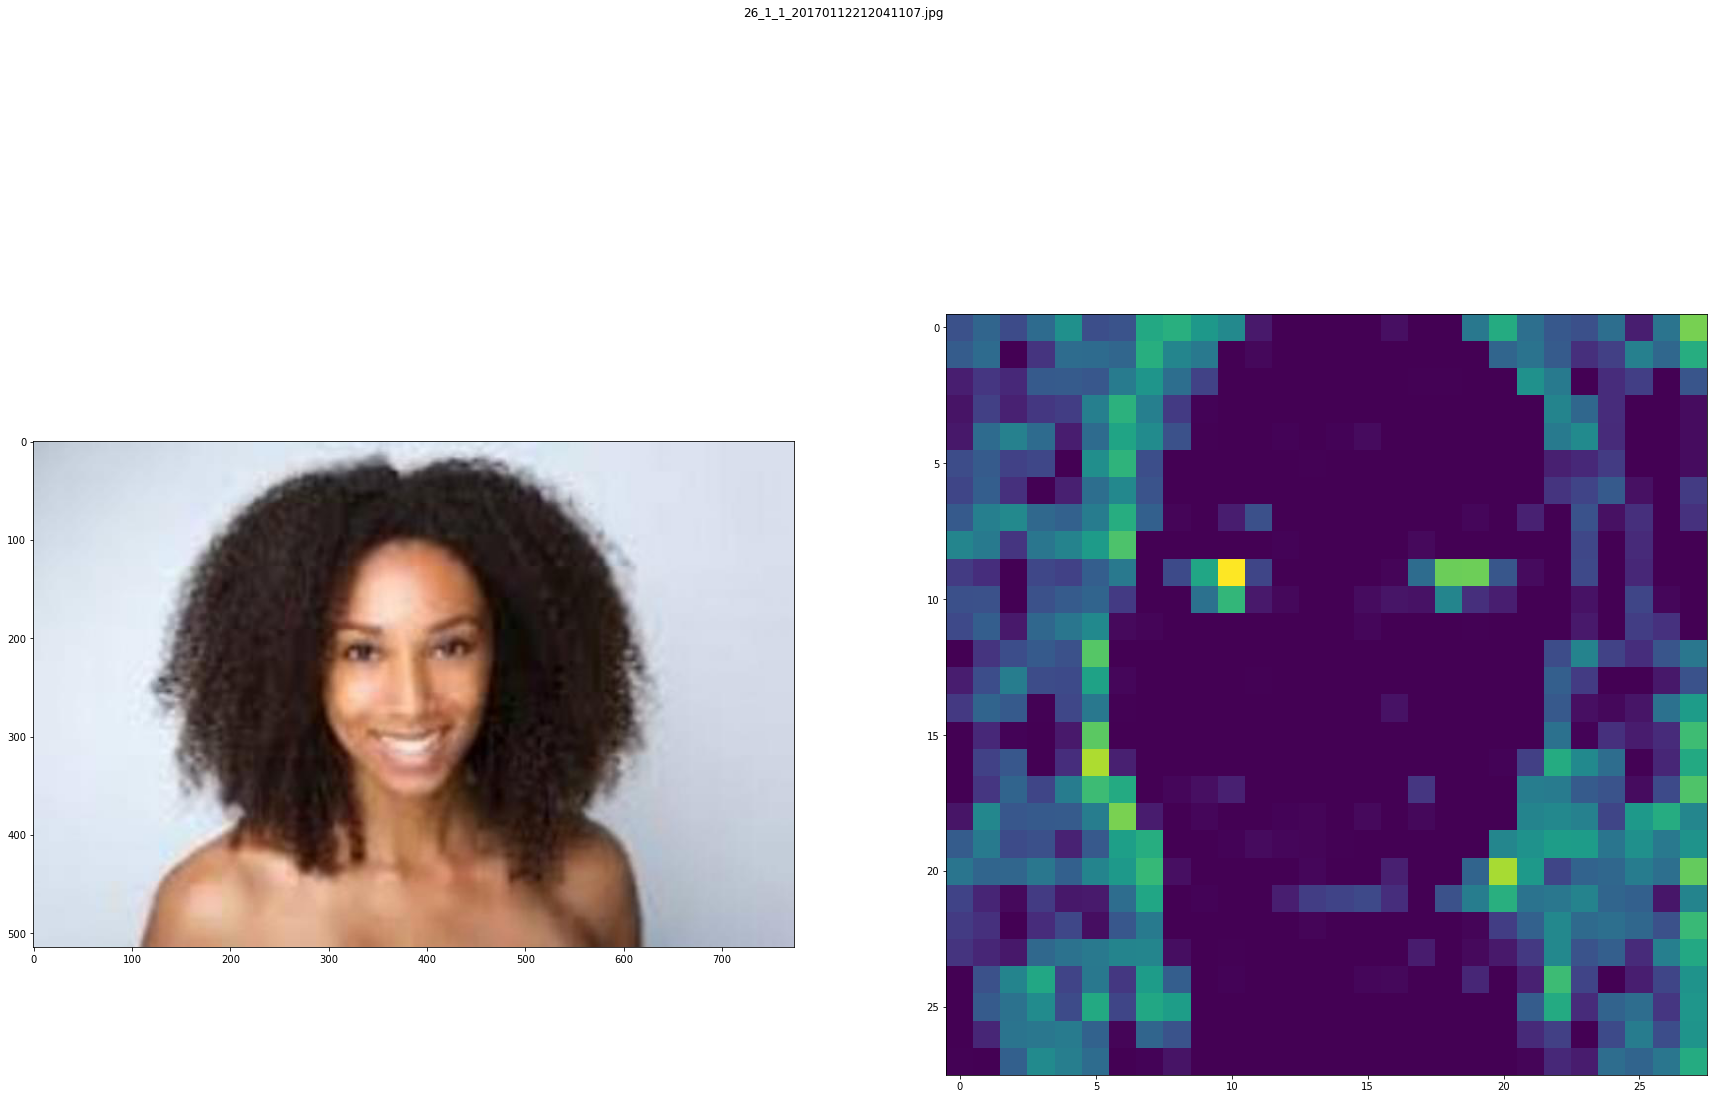

age =  48 	 sex =  woman


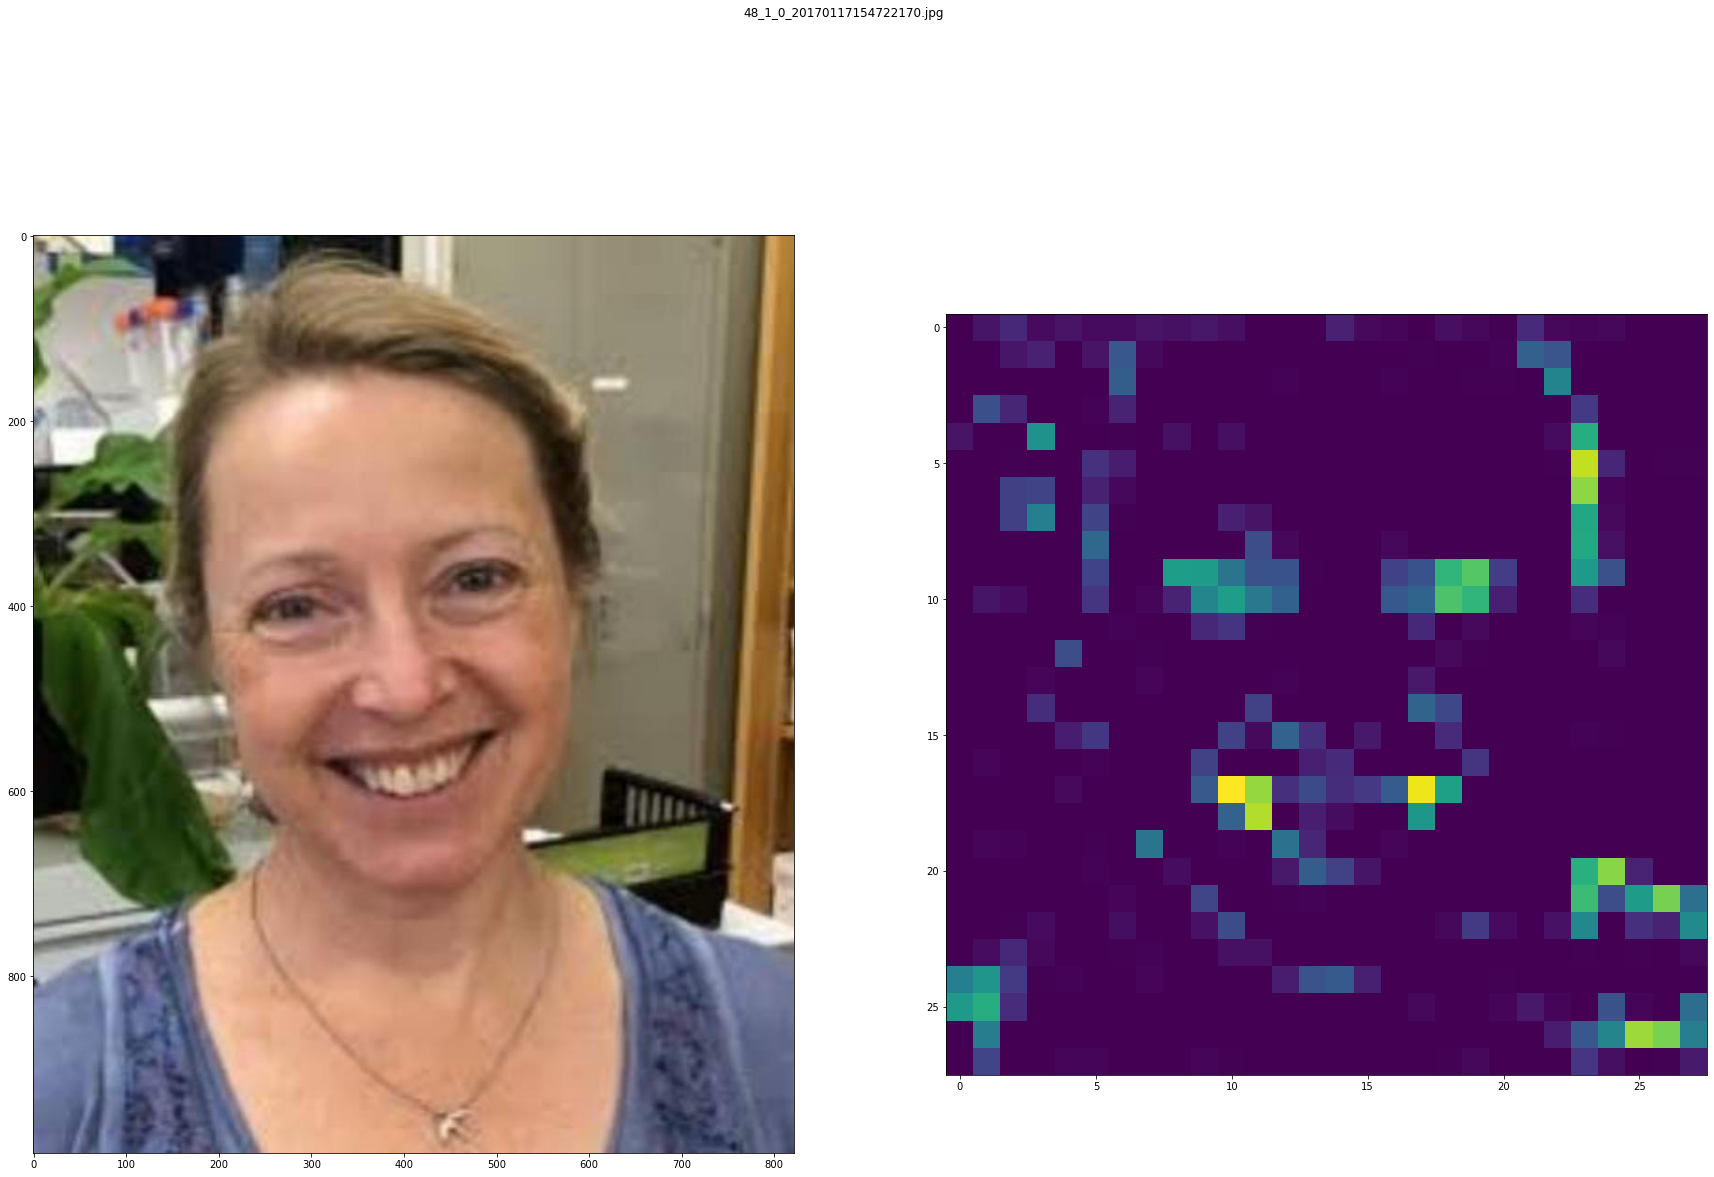

In [29]:
for i in range(5):
    print("age = ", age_array[i], "\t", "sex = ", "man" if sex_array[i] == '0' else "woman")
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(files_sublist[i])
    img = plt.imread(os.path.join(IMAGE_PATH,files_sublist[i]))
    ax1.imshow(img)
    ax2.imshow(embedding_array[i])
    plt.show()

In [30]:
print("shape embedding_array = \t", np.shape(embedding_array))

shape embedding_array = 	 (14613, 28, 28)


In [31]:
print("shape age_array = ", np.shape(age_array))

shape age_array =  (14613,)


In [33]:
values, counts = np.unique(age_array, return_counts=True)
for v,c in zip(values, counts):
    print(v, c)

1 670
10 105
100 6
101 1
105 3
11 34
110 5
111 1
12 78
13 43
14 93
15 117
16 138
17 99
18 149
19 59
2 302
20 173
21 215
22 242
23 263
24 519
25 458
26 1423
27 385
28 557
29 363
3 184
30 429
31 207
32 402
33 94
34 266
35 556
36 294
37 200
38 201
39 168
4 178
40 324
41 77
42 154
43 101
44 66
45 269
46 93
47 110
48 109
49 99
5 116
50 206
51 88
52 145
53 138
54 220
55 164
56 150
57 55
58 169
59 38
6 78
60 175
61 99
62 84
63 65
64 27
65 162
66 47
67 50
68 57
69 37
7 76
70 88
71 13
72 67
73 40
74 18
75 93
76 36
77 19
78 35
79 15
8 167
80 81
81 13
82 24
83 12
84 15
85 96
86 23
87 5
88 21
89 19
9 105
90 46
91 2
92 8
93 4
95 5
96 12
99 3


In [34]:
values, counts = np.unique(sex_array, return_counts=True)
for v,c in zip(values, counts):
    print(v, c)

0 7629
1 6983
3 1
